# HPGE Gamma Spectroscopy - Spectral Analysis

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal


Calculation of time passed since IAEA reference sheet date

In [2]:
time_string = "1 January, 2019"
ref = time.strptime(time_string, "%d %B, %Y") #time_struct object of decay correction reference date
now = time.strptime(time.ctime())
dt = time.mktime(now)-time.mktime(ref) #time (in seconds) passed
dt

157247561.0

### Webscraping NNDC Database for gamma radiation

As Interspec did not reference the data used for reference photopeak, we decided to use database from `https://www.nndc.bnl.gov/nudat3/dec_search.jsp`. Python request object below was created by copying cURL of the webpage, and converted to python code with `https://curlconverter.com`

In [3]:
def nndc(nuc):
    '''This function takes in nuclide name nuc as input and 
       obtain nndc dataset of gamma radiation, output as pandas DataFrame'''
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Language': 'zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
        'Content-Type': 'application/x-www-form-urlencoded',
        # 'Cookie': 'JSESSIONID=D70C39328A761ABB0BA3274BD146F79E; _ga=GA1.4.404777615.1698689054; _ga_BCK578C8FS=GS1.1.1699970881.3.0.1699970881.0.0.0; _ga_M7918ZRR2Q=GS1.1.1699970881.3.0.1699970881.0.0.0; _gid=GA1.2.165605393.1699970882; _ga_F5YKVFGCQT=GS1.1.1699970895.3.1.1699971054.0.0.0; _ga=GA1.1.404777615.1698689054; _ga_92P36DL448=GS1.4.1699970895.3.1.1699971191.60.0.0',
        'Origin': 'https://www.nndc.bnl.gov',
        'Pragma': 'no-cache',
        'Referer': 'https://www.nndc.bnl.gov/nudat3/indx_dec.jsp',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-User': '?1',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
        'sec-ch-ua': '"Google Chrome";v="119", "Chromium";v="119", "Not?A_Brand";v="24"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"macOS"',
    }

    data = {
        'spnuc': 'name',
        'nuc': nuc,
        'z': '',
        'a': '',
        'n': '',
        'zmin': '',
        'zmax': '',
        'amin': '1',
        'amax': '240',
        'nmin': '',
        'nmax': '',
        'evenz': 'any',
        'evena': 'any',
        'evenn': 'any',
        'tled': 'disabled',
        'tlmin': '0',
        'utlow': 'FS',
        'tlmax': '1E10',
        'utupp': 'GY',
        'dmed': 'disabled',
        'dmn': 'ANY',
        'rted': 'disabled',
        'rtn': 'ANY',
        'reed': 'disabled',
        'remin': '0',
        'remax': '10000',
        'ried': 'disabled',
        'rimin': '0',
        'rimax': '200',
        'ord': 'zate',
        'out': 'file',
        'unc': 'stdandard',
        'sub': 'Search',
    }

    response = requests.post('https://www.nndc.bnl.gov/nudat3/dec_searchi.jsp', headers=headers, data=data)
    soup = BeautifulSoup(response.content,'html.parser')
    nndc_df = pd.read_csv(io.StringIO(soup.find('pre').text), sep="\t")
    #rename nndc columns
    nndc_col = {'Rad Ene.  ' : 'nndc_peak_energy','Unc       .2':'BR_err','Unc       ':'E_err','T1/2 (num)        ':'T1/2(s)' } 
    nndc_df.rename(columns = nndc_col,inplace=True)
    #adding branching ratios of gamma rad. from electron capture and other pathways of the same energy
    nndc_df['BR'] = nndc_df.groupby(['nndc_peak_energy'])['Rad Int.  '].transform('sum')/100 #BR = intensity/100
    nndc_df['rounded_energy'] = round(nndc_df['nndc_peak_energy'],ndigits=0)
    nndc_df['nuc'] = nuc
    #nndc_df['BR_err'] = nndc_df['BR_err'].astype(float)/100
    return nndc_df[['nndc_peak_energy','E_err','BR','BR_err','rounded_energy','nuc','T1/2(s)']]
    

In [4]:
#store reference photopeaks as pd.DataFrame
pp_df = pd.read_csv('Data/Photopeak_References/PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals

def peak_df(filename):
    ''' This function converts the peak data csv into  a pandas dataframe 
       Input: filename - file path of csv
       Output: df2 '''
    df = pd.read_csv(filename,delimiter = ',',header = [0,1]).droplevel(1,axis = 1)
    rename_dict = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'
    ,' FWHM':'FWHM','  Net_Area':'Net_Area_Count','Reduced':'Reduced_chi2','   Net_Area':'Net_Area_err'}
    #dtype_dict = {'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float,'FWHM':float,'Net_Area_Count':float,''}
    df.rename(columns = rename_dict,inplace = True)
    df.dropna(subset='Nuclide',inplace = True)
    df.reset_index(inplace=True) #for merging nuc column later
    return df[['Centroid','Nuclide','Photopeak_Energy','Net_Area_Count','Net_Area_err','Peak_CPS','FWHM','Reduced_chi2']]

def nndc_all(df):
    '''This function takes in the peak dataframes and find all the nuclides identified, 
       then  output a concatenated dataframe of nndc gamma radiation data for each nuclide (obtained from nndc function defined above)'''
    nuc = df['Nuclide'].dropna().drop(df[df['Nuclide']=='Annihilation'].index)
    nuc = list(set([i[0] for i in nuc.str.findall('\w+\d+')])) #unique nuclide names
    df2 = pd.DataFrame()
    for i in nuc:
        nndc_df = nndc(i)
        df2 = pd.concat([df2,nndc_df])
    return df2



    
# class peak():
#     def __init__(self,df):
#         self.df = df
#     def name(self,name):
#         return self.df.loc[self.df.isin({'Nuclide':[name]})]
        


/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_95425/1600657514.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('Data/Photopeak_References/PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


In [338]:
path1 = 'Data/Peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV' #peak sample 1
path2 = 'Data/Peaks/peaks_Sample2_31_10_23_14_08.CSV'
path3 = 'Data/Peaks/peaks_Sample3_refitted_25_11_23__Sat_16_05.CSV'
path4 = 'Data/Peaks/peaks_Sample4_refitted_25_11_23__Sat_16_50.CSV'
path5 = 'Data/Peaks/peaks_IAEA_sample_05_12_22.CSV'
path_bg = 'Data/Peaks/peaks_background_17_10_23.csv'
path_bg_2022 = 'Data/Peaks/peaks_HPGe_21.02.2022_background_recal.CSV'
path_list = [path_bg,path1,path2,path3,path4,path5,path_bg_2022]
# df_1 = peak_df(path1)
# df_2 = peak_df(path2)
# df_bg= peak_df(path_bg)
df_initial = pd.concat([peak_df(path) for path in path_list],keys = range(len(path_list)))

In [339]:
# run this when using new peak dataframes
# nndc_df = nndc_all(df_initial.reset_index())
# nndc_df.to_csv('nndc_df.csv')

In [343]:
nndc_df = pd.read_csv('nndc_df.csv',index_col=0)

In [344]:
def peak_df_new(df):
    '''This function adds additional columns to input peak df:
       1. BR -branching ratio by merging the dataframe from nndc_all() with df on rounded energy 
       (due to discrepancies between interspec and nndc photopeak datasets) 
       2. Centroid error
       3. FWHM error
       4. Resolution
       5. Resolution error
       6. Effective activity - CPS over BR
       
       Input: peak dataframe
       Output: peak dataframe with added columns'''
    df['rounded_energy'] = round(df['Photopeak_Energy'],ndigits = 0)
    df = df.dropna(subset='Nuclide').drop(df[df['Nuclide']=='Annihilation'].index)
    nuc = df['Nuclide']
    #convert nuclide names into nndc format, e.g. Pa234m -> Pa234
    df['nuc'] =  pd.Series([i[0] for i in nuc.str.findall('\w+\d+')])
    df2 = df.merge(nndc_df,how = 'left' ,on = ['rounded_energy', 'nuc'])
    df2 = df2.groupby('Photopeak_Energy').max()
    df2['Centroid_err'] = df2['FWHM']/2/np.sqrt(2*np.log(2)*df2['Net_Area_Count'])#Centroid error
    df2['FWHM_err'] = df2['Centroid_err']*np.sqrt(np.log(2))*2 #FWHM error 
    df2['Resolution'] = df2['FWHM']/df2['Centroid']
    df2['Resolution_err']= df2['Resolution']*np.sqrt((df2['Centroid_err']/df2['Centroid'])**2+(df2['FWHM_err']/df2['FWHM'])**2)
    df2['Peak_CPS_BR'] = df2['Peak_CPS']/df2['BR']
    df2.dropna(inplace = True)
    return df2.reset_index()

In [345]:
#concat all dataframes
df = pd.concat([peak_df_new(peak_df(path)) for path in path_list],keys = range(len(path_list)))

In [346]:
iaea_df = df.loc[5]

In [347]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_red = chi2/df
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    print(f' chi2: {chi2} \n reduced chi2: {chi2_red}\n chi2 p-value: {chi2_p}')
    return [chi2,chi2_red]

In [ ]:
marker_list = list(Line2D.markers.keys())

Text(0, 0.5, 'Error on FWHM/keV')

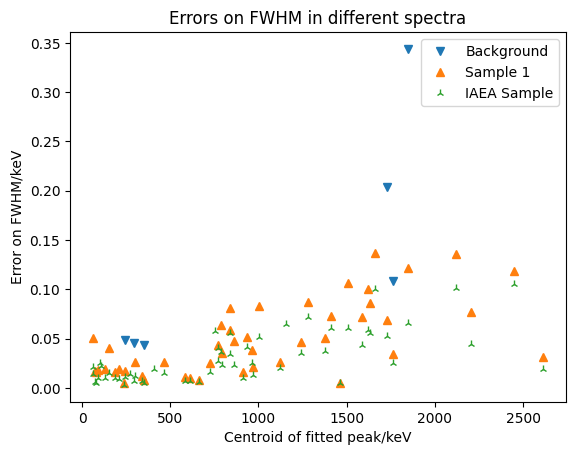

In [144]:
label_list = ['Background 2023','Sample 1','Sample 2','Sample 3','Sample 4','IAEA Sample','Background 2022']
plt.figure()
plt.title(r'Errors on FWHM in different spectra')
for i in [0,1,5]:
    plt.plot(df.loc[i]['Centroid'], df.loc[i]['FWHM_err'],marker_list[3+i],label = label_list[i])
plt.legend()
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Error on FWHM/keV')
#plt.savefig('centroid_err.pdf')

Text(0, 0.5, 'Reduced $\\chi^2$')

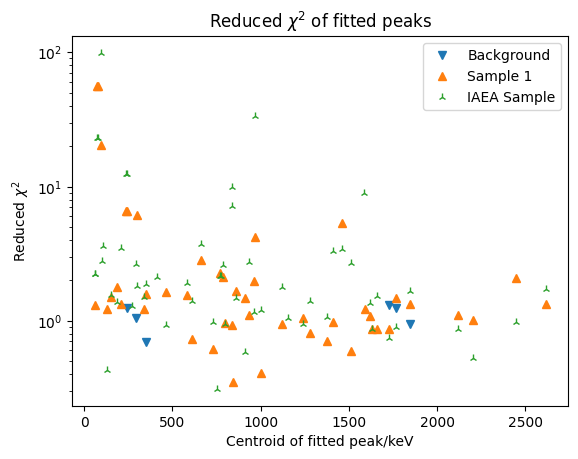

In [16]:
plt.figure()
plt.title(r'Reduced $\chi^2$ of fitted peaks')

for i in [0,1,5]:
    plt.plot(df.loc[i]['Centroid'], df.loc[i]['Reduced_chi2'],marker_list[3+i],label = label_list[i])
plt.legend()
plt.yscale('log')
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Reduced $\chi^2$')
#plt.savefig('reduced_chi2_gaussian.pdf')


FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

## Energy Calibration

In [359]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula

# grad = 0.6775230169 #gradient
# interc = -0.3439140022 #intercept
# energy_to_chan = np.poly1d([1/grad,-interc/grad])


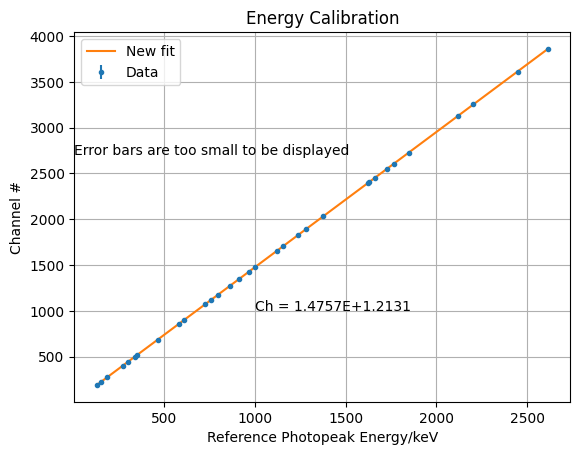

In [362]:
#df_new = df_1.dropna(subset = ['Photopeak_Energy']) #drop unidentified peaks
df_new = df.loc[5][df.loc[5]['Reduced_chi2']<2] #omit peaks with poor fit (reduced chi2 >2)
x = df_new['nndc_peak_energy']
y = energy_to_chan(df_new['Centroid'])
y_err = 1/np.sqrt(b**2-4*a*(c-x))*df_new['Centroid_err']
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True,w = 1/y_err) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)

#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'Data')
plt.plot(x,peak_fit(x),label = 'New fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('Reference Photopeak Energy/keV')
plt.text(1000,1000,f'Ch = {popt_peak[0]:.4f}E+{popt_peak[1]:.4f}')
plt.text(1,2700,'Error bars are too small to be displayed')
plt.grid()
#plt.savefig('energy_calibration.pdf')

In [260]:
(perr_peak/popt_peak)**2

array([3.33161708e-09, 2.25113950e-03])

Error propagation for transforming (E to Channel) fit into (Channel to E) fit:\
$C = a*E+b \rightarrow E = m*C+n$\
$m = 1/a, \Delta m = \Delta a / a^2 $\
$n = -b/a, \Delta n = |n * \sqrt{(\Delta a / a)^2+(\Delta b / b)^2}| $

In [369]:
p_new = [1/popt_peak[0],-popt_peak[1]/popt_peak[0]]
p_new_err = [perr_peak[0]/popt_peak[0]**2,abs(p_new[1]*np.sqrt(np.sum((perr_peak/popt_peak)**2)))]
def chan_to_energy(Ch):
    return p_new[0]*Ch+p_new[1]

print(f'Linear fit (energy to channel) using peak energy: E = {p_new[0]:.6f}Ch {p_new[1]:.6f}')
print(f'Original quadratic fit (energy to channel) : E = {a:.6g}Ch^2 + {b:.6f}Ch + {c}' )
print('Errors on new fit:')
print(perr_peak*np.array([(perr_peak/popt_peak)[0]]))

Linear fit (energy to channel) using peak energy: E = 0.677643Ch -0.822019
Original quadratic fit (energy to channel) : E = 8.38788e-08Ch^2 + 0.677523Ch + -0.3439140022
Errors on new fit:
[4.91647822e-09 3.32207502e-06]


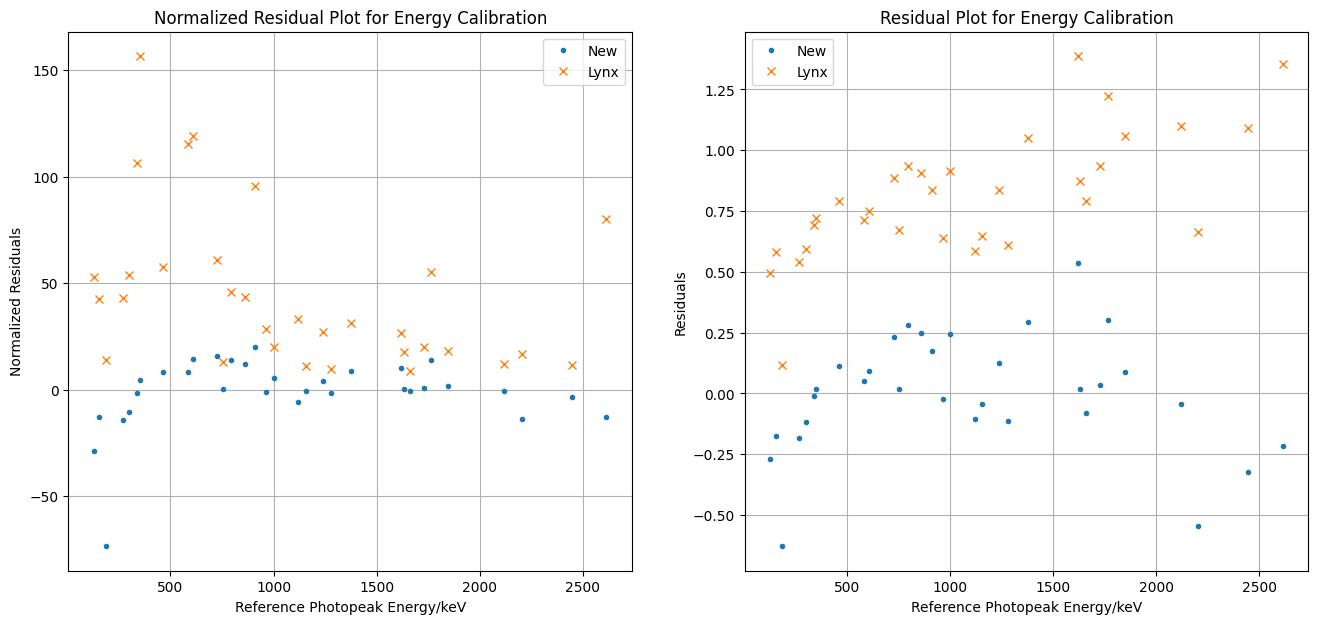

In [22]:
fig,ax = plt.subplots(1,2,figsize = (16,7))
ax[0].set_title('Normalized Residual Plot for Energy Calibration')
ax[0].plot(x,(y-peak_fit(x))/y_err,'.',label= 'New')
ax[0].plot(x,(y-energy_to_chan(x))/y_err,'x',label = 'Lynx')
ax[0].set_xlabel('Reference Photopeak Energy/keV')
ax[0].set_ylabel('Normalized Residuals')
ax[0].grid()
ax[0].legend()
ax[1].set_title('Residual Plot for Energy Calibration')
ax[1].plot(x,(y-peak_fit(x)),'.',label= 'New')
ax[1].plot(x,(y-energy_to_chan(x)),'x',label = 'Lynx')
ax[1].set_xlabel('Reference Photopeak Energy/keV')
ax[1].set_ylabel('Residuals')
ax[1].grid()
ax[1].legend()
plt.savefig('energy_norm_resid.pdf')

<ErrorbarContainer object of 3 artists>

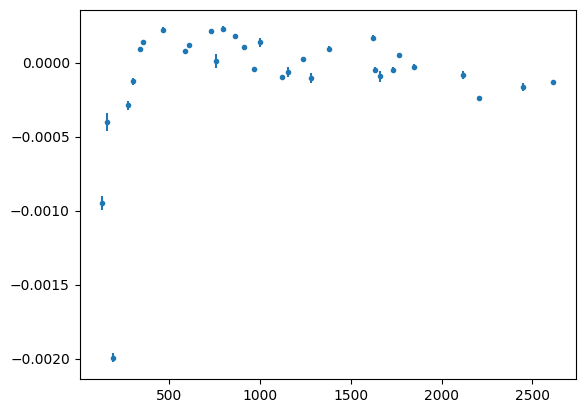

In [199]:
plt.errorbar(x,(y-peak_fit(x))/y,yerr= y_err/y,fmt = '.',label= 'New')

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


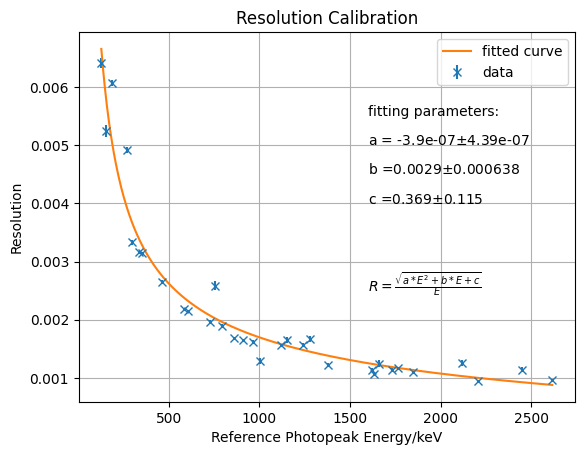

In [363]:
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy

def res_fit_2(peak_energy,a,b,c):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy**2+b*peak_energy+c)/peak_energy

y_fwhm2 = df_new['FWHM']*df_new['FWHM']
p_fwhm2,cov_fwhm2 = np.polyfit(x,y_fwhm2, 1,cov = True)

x_res = df_new['nndc_peak_energy']
y_res = df_new['Resolution']
y_res_err = df_new['Resolution_err']
res_par, res_cov = curve_fit(res_fit_2,x_res,y_res, p0 = [0.00001,0.00055, 1.8])
res_fit_err = np.sqrt(np.diag(res_cov))
x_plot = np.linspace(min(x_res),max(x_res),500)

plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(x_res,y_res,yerr = y_res_err,fmt = 'x',label = 'data')
plt.plot(x_plot,res_fit_2(x_plot,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1600,0.0055,f'fitting parameters:')
plt.text(1600,0.005,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.0045,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')
plt.text(1600,0.004,f'c ={res_par[2]:.3g}' + r'$\pm$'+ f'{res_fit_err[2]:.3g}')
plt.text(1600,0.0025,r'$R = \frac{\sqrt{a * E^2+b*E+c}}{E}$')
plt.grid()
#plt.savefig('res_calibration.pdf')

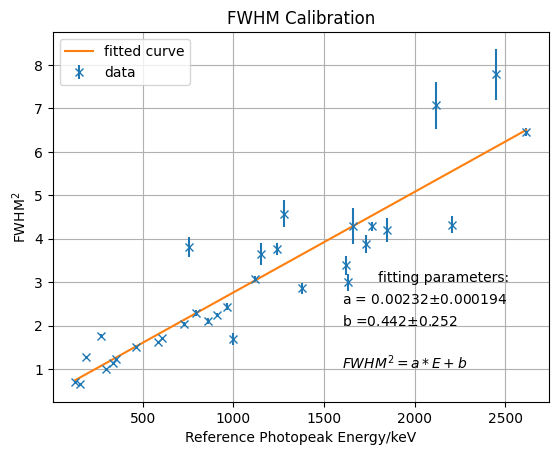

In [364]:
fwhm2 = np.poly1d(p_fwhm2)
fwhm2_err = 2*df_new['FWHM']*df_new['FWHM_err']
p_fwhm2_err = np.sqrt(np.diag(cov_fwhm2))
plt.figure()
plt.title('FWHM Calibration')
plt.errorbar(x,y_fwhm2,yerr = fwhm2_err,fmt = 'x',label = 'data')
plt.plot(x_plot,fwhm2(x_plot), label = 'fitted curve')
plt.ylabel(r'FWHM$^2$')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1800,3,f'fitting parameters:')
plt.text(1600,2.5,f'a = {p_fwhm2[0]:.3g}' + r'$\pm$'+ f'{p_fwhm2_err[0]:.3g}')
plt.text(1600,2,f'b ={p_fwhm2[1]:.3g}' + r'$\pm$'+ f'{p_fwhm2_err[1]:.3g}')
#plt.text(1600,1.5,f'c ={p_fwhm2[2]:.3g}' + r'$\pm$'+ f'{p_fwhm2_err[2]:.3g}')
plt.text(1600,1,r'$FWHM^2 = a * E+b$')
plt.grid()

In [262]:
fwhm2 = np.poly1d(p_fwhm2)
print('polyfit:')
print(p_fwhm2)
print(p_fwhm2_err)
print('curvefit:')
print(res_par)
print(res_fit_err)



polyfit:
[0.00231882 0.44197877]
[1.94244474e-04 2.52411465e-01]
curvefit:
[-3.89933347e-07  2.90009910e-03  3.69410774e-01]
[4.38574396e-07 6.37692815e-04 1.14829103e-01]
 chi2: 2254.2821105071785 
 reduced chi2: 77.73386587955788
 chi2 p-value: 0.0
 chi2: 1412.3520188196808 
 reduced chi2: 48.701793752402786
 chi2 p-value: 0.0


,Calibration,Energy,Energy (Lynx),Resolution,FWHMM^2
0,Param,"[0.6776430057555147, -0.8220186147547165]","[8.387880257e-08, 0.6775230169, -0.3439140022]","[-3.899333469121279e-07, 0.002900099099419502,...","[0.002318824032827287, 0.4419787691134333]"
1,Param_err,"[3.911366394071136e-05, 0.03900166770144255]",not given,"[4.385743964908731e-07, 0.0006376928153246805,...","[0.0001942444735052647, 0.2524114646637192]"
2,chi^2,7926.504581,109426.138711,2254.282111,1412.352019
3,reduced chi^2,264.216819,3773.315128,77.733866,48.701794


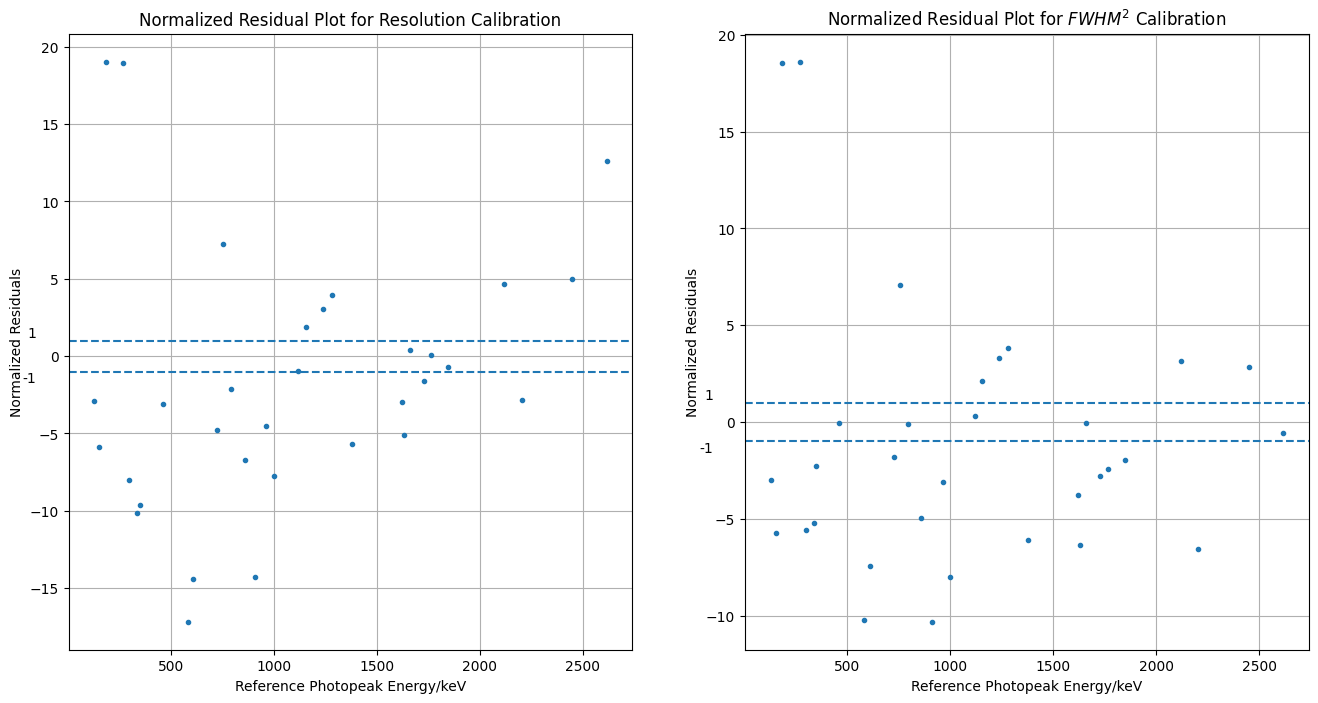

In [266]:
fig, ax = plt.subplots(nrows = 1,ncols=2,figsize = (16,8))
ax[0].set_title('Normalized Residual Plot for Resolution Calibration')
ax[0].plot(x_res,(y_res-res_fit_2(x_res,*res_par))/y_res_err,'.')
ax[1].set_title(r'Normalized Residual Plot for $FWHM^2$ Calibration')
ax[1].plot(x,(y_fwhm2-fwhm2(x))/fwhm2_err,'.')
for i in range(2):
    ax[i].set_xlabel('Reference Photopeak Energy/keV')
    ax[i].set_ylabel('Normalized Residuals')
    ax[i].grid()
    ax[i].axhline(1,linestyle = '--')
    ax[i].axhline(-1,linestyle = '--')
    ax[i].text(-150, 1, '1', ha='right', va='bottom')
    ax[i].text(-150, -1, '-1', ha='right', va='top')
#plt.savefig('res_norm_resid.pdf')
#plt.figure()
# plt.title(r'Normalized Residual Plot for $FWHM^2$ Calibration')
# plt.plot(x,(y_fwhm2-fwhm2(x))/fwhm2_err,'.')
# plt.xlabel('NNDC Reference Photopeak Energy/keV')
# plt.ylabel('Normalized Residuals')
# plt.grid()
# plt.axhline(1,linestyle = '--')
# plt.axhline(-1,linestyle = '--')
# plt.text(-150, 1, '1', ha='right', va='bottom')
# plt.text(-150, -1, '-1', ha='right', va='top')
# plt.savefig('res_norm_resid.pdf')

### Absolute efficiency

Activity is given by:
$$A = \frac{CPS}{BR*\varepsilon(E)}$$
where\
$A$   - Activity (Activity per sample mass * sample mass)\
$CPS$ - Counts per seconds (Net area count/live time)\
$BR$  - Branching Ratio\
$\varepsilon(E)$ - full energy peak efficiency (dependent on energy, with sample geometry taken into account)

Sources of errors on the fit:
No correction for true-coincidence summing\
Most of the nuclides in U238 and Th232 decay series have complicated decay schemes, and due to close geometry of Marinelli beaker, true coincidence summing (summing of gamma rays emitted in coincidence and resulting in summed peaks) is unavoidable.




Tl208, K40 and Th234 92.8keV peaks are removed\
Reasons:\
Tl208 & K40: large background contribution  $\rightarrow$ peaked area correction gives large error\
Also,they have significant escape peaks which complicates the analysis

92.4keV and 92.8keV lines of Th234 may be unresolved. In fact, Interspec fails to fit the triplets before the Th234 line.


In [287]:
19.8*0.5**(dt/949300000.0)

17.67504169003911

In [286]:
iaea_df[iaea_df['nuc']=='Cs137']['T1/2(s)']

43    949300000.0
Name: T1/2(s), dtype: float64

In [367]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
iaea_df = iaea_df[~((iaea_df['Nuclide'].isin(['K40','Tl208']) )  | 
(iaea_df['nndc_peak_energy']==92.8))]
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[6][['nndc_peak_energy','Peak_CPS_BR']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[6] contains background peaks
iaea_df['Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_eff = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
#error propagation (assume poisson noise for peak cps error)
iaea_eff_err =iaea_eff* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

# iaea_eff_err =iaea_eff* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2 +
# (iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass
def eff_fit(x,a,b,c,d,e):
    '''Efficiency fit function
       x: energy (independent variable)
       p: parameter array
       this form of equation is suggested in Gilmore p.193'''
    return np.exp(np.poly1d([a,b,c,d,e])(np.log(x)))
x_eff = iaea_df['nndc_peak_energy']
eff_par, eff_cov = curve_fit(eff_fit,x_eff,iaea_eff,p0 = [0.0001,0.001,0.1,0.1,0.1])
eff_par_err = np.sqrt(np.diag(eff_cov))
print('efficiency fit parameters:', eff_par)
print('efficiency fit parameters errors:',eff_par_err)

#DataFrame to store above least-square fits' information
fit_df = pd.DataFrame({'Calibration':['Param','Param_err','chi^2','reduced chi^2'],
    'Energy':[p_new,p_new_err]+chi2_prob(peak_fit(x),y,y_err,len(x)-2),
    'Energy (Lynx)':[[a,b,c],'not given']+chi2_prob(energy_to_chan(x),y,y_err,len(x)-3),
    'Resolution':[res_par,res_fit_err]+chi2_prob(res_fit_2(x,*res_par),y_res,y_res_err,len(x)-3),
    'FWHMM^2':[p_fwhm2,p_fwhm2_err]+chi2_prob(fwhm2(x),y_fwhm2,2*df_new['FWHM']*df_new['FWHM_err'],len(x)-2),
    'Efficiency' : [eff_par,eff_par_err]+chi2_prob(eff_fit(x_eff,*eff_par),iaea_eff,iaea_eff_err,df = len(iaea_df)-len(eff_par))
    })

#fit_df.set_index('Calibration',inplace = True)


efficiency fit parameters: [-2.51796883e-01  6.36172018e+00 -5.97831469e+01  2.46767861e+02
 -3.79429371e+02]
efficiency fit parameters errors: [1.04520660e-01 2.50800514e+00 2.23933564e+01 8.81734442e+01
 1.29185460e+02]
 chi2: 7926.504581006589 
 reduced chi2: 264.21681936688634
 chi2 p-value: 0.0
 chi2: 109426.13871119541 
 reduced chi2: 3773.3151279722556
 chi2 p-value: 0.0
 chi2: 2254.2821105071785 
 reduced chi2: 77.73386587955788
 chi2 p-value: 0.0
 chi2: 1412.3520188196808 
 reduced chi2: 47.078400627322694
 chi2 p-value: 0.0
 chi2: 258.99052182932644 
 reduced chi2: 6.316841995837231
 chi2 p-value: 0.0


In [368]:
fit_df.loc[4] = ['Param_round'] + [['%s' % float('%.3g' %n) for n in row ] for row in fit_df.T[0][1:]]
fit_df.loc[5] = ['Param_err_round'] + [['%s' % float('%.3g' %n) for n in fit_df.T[1][1]]]+['not given']+[['%s' % float('%.3g' %n) for n in row] for row in fit_df.T[1][3:]] 
fit_df.loc[6] = ['Fit function']+['y=a*x+b','y=a*x^2+b*x+c','y=sqrt(a*x^2+b*x+c)/x','y=a*x+cxf    , b','y=exp(poly(ln(x),deg=5)']
fit_df.loc[7] = ['Variable x']+['Channel Number','Channel Number','Energy (keV)','Energy (keV)','Energy (keV)']
fit_df.loc[8] = ['Variable y']+['Energy (keV)','Energy (keV)','Resolution','FWHM^2','Efficiency']
fit_df

,Calibration,Energy,Energy (Lynx),Resolution,FWHMM^2,Efficiency
0,Param,"[0.6776430057555147, -0.8220186147547165]","[8.387880257e-08, 0.6775230169, -0.3439140022]","[-3.899333469121279e-07, 0.002900099099419502,...","[0.002318824032827287, 0.4419787691134333]","[-0.25179688301468706, 6.361720180806226, -59...."
1,Param_err,"[3.911366394071136e-05, 0.03900166770144255]",not given,"[4.385743964908731e-07, 0.0006376928153246805,...","[0.0001942444735052647, 0.2524114646637192]","[0.10452065958171061, 2.5080051433460184, 22.3..."
2,chi^2,7926.504581,109426.138711,2254.282111,1412.352019,258.990522
3,reduced chi^2,264.216819,3773.315128,77.733866,47.078401,6.316842
4,Param_round,"[0.678, -0.822]","[8.39e-08, 0.678, -0.344]","[-3.9e-07, 0.0029, 0.369]","[0.00232, 0.442]","[-0.252, 6.36, -59.8, 247.0, -379.0]"
5,Param_err_round,"[3.91e-05, 0.039]",not given,"[4.39e-07, 0.000638, 0.115]","[0.000194, 0.252]","[0.105, 2.51, 22.4, 88.2, 129.0]"
6,Fit function,y=a*x+b,y=a*x^2+b*x+c,y=sqrt(a*x^2+b*x+c)/x,"y=a*x+cxf , b","y=exp(poly(ln(x),deg=5)"
7,Variable x,Channel Number,Channel Number,Energy (keV),Energy (keV),Energy (keV)
8,Variable y,Energy (keV),Energy (keV),Resolution,FWHM^2,Efficiency


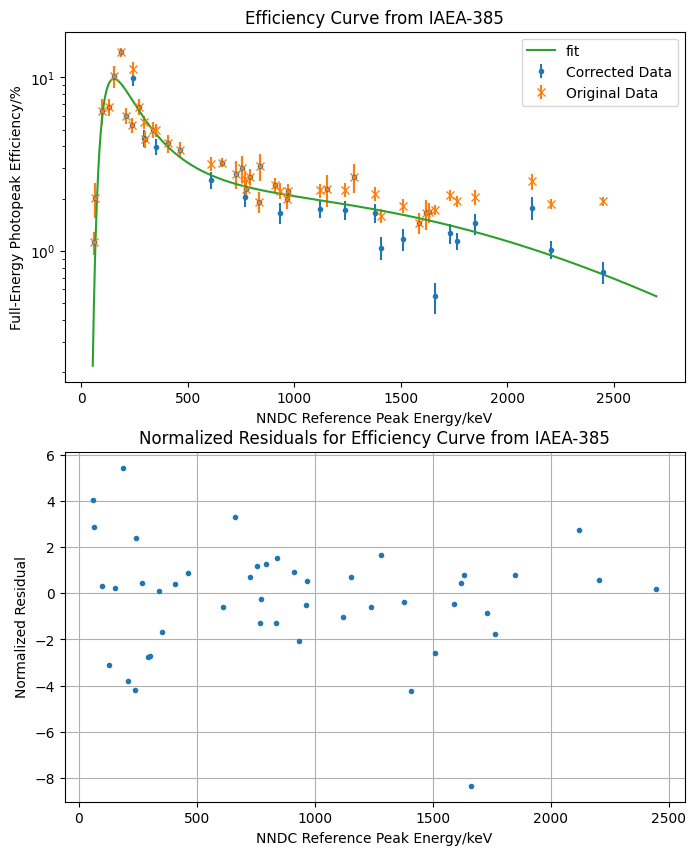

In [290]:
fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

ax[0].set_title('Efficiency Curve from IAEA-385')
ax[0].errorbar(x_eff,100*iaea_eff,yerr =100*iaea_eff_err, fmt = '.',label = 'Corrected Data')
ax[0].errorbar(x_eff,100*iaea_df['Peak_CPS_BR']/(iaea_df['Abs_Activity']*iaea_mass),yerr =100*iaea_eff_err, fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*eff_fit(np.linspace(55,2700,10000),*eff_par),label = 'fit')
ax[0].set_xlabel('NNDC Reference Peak Energy/keV')
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
ax[1].plot(x_eff,(iaea_eff-eff_fit(x_eff,*eff_par))/iaea_eff_err,'.')
ax[1].set_xlabel('NNDC Reference Peak Energy/keV')
ax[1].set_ylabel('Normalized Residual')
ax[1].grid()
#plt.xscale('log')
#plt.figure()
# plt.title(r'Normalized Residual Plot for $FWHM^2$ Calibration')
# plt.plot(x,(y_fwhm2-fwhm2(x))/fwhm2_err,'.')
# plt.xlabel('NNDC Reference Photopeak Energy/keV')
# plt.ylabel('Normalized Residuals')
# plt.grid()
# plt.axhline(1,linestyle = '--')
# plt.axhline(-1,linestyle = '--')
# plt.text(-150, 1, '1', ha='right', va='bottom')
# plt.text(-150, -1, '-1', ha='right', va='top')

In [125]:
df.loc[5][df.loc[5]['nuc']== 'Pa234'][['Photopeak_Energy','BR']]

,Photopeak_Energy,BR
27,786.25,0.000544
36,1000.99,0.008420


### Normalization of Spectrum 3

In [129]:
spec_path_list = ['Data/Spectra/Background_16_10_23_Mon_14_50.csv',
'Data/Spectra/Sample1_23_10_23_Mon_10_39.csv','Data/Spectra/Sample2_31_10_23_14_08.csv',
'Data/Spectra/Sample3_07_11_23__Tue_11_50.csv', 'Data/Spectra/Sample4_13_11_23_Mon_14_06.csv',
'Data/Spectra/IAEA_sample_05.12.22 copy.csv','Data/Spectra/HPGe_21.02.2022_background.csv']
spec = [np.loadtxt(path,delimiter = ',',skiprows = 7,unpack = True) for path in spec_path_list]


In [2]:
import os
import csv
from os import listdir

In [8]:
spec_list = sorted(listdir('Data/Spectra')[1:])
spec = [np.loadtxt(f'Data/Spectra/{path}',delimiter = ',',skiprows = 7,unpack = True) for path in spec_list]

In [9]:
spec_list

['Background_16_10_23_Mon_14_50.csv',
 'HPGe_21.02.2022_background.csv',
 'HPGe_Background_12.12.23.csv',
 'HPGe_Sample3_07.12.23.csv',
 'IAEA_Sample_20_11_23_Mon_10_58.csv',
 'IAEA_sample_05.12.22 copy.csv',
 'Sample1_23_10_23_Mon_10_39.csv',
 'Sample2_31_10_23_14_08.csv',
 'Sample3_07_11_23__Tue_11_50.csv',
 'Sample4_13_11_23_Mon_14_06.csv']

In [56]:
spec_recal_list = ['Background_16_10_23_Mon_14_50',
'Sample1_23_10_23_Mon_10_39','Sample2_31_10_23_14_08',
'Sample3_07_11_23__Tue_11_50', 'Sample4_13_11_23_Mon_14_06','IAEA_sample_05.12.22 copy','HPGe_21.02.2022_background']

def spec_recal(filename):

    spec = np.loadtxt(f'Data/Spectra/{filename}.csv',delimiter = ',',skiprows = 7,unpack = True)
    spec[1] = 1/popt_peak[0]*spec[0]-popt_peak[1]/popt_peak[0]
    np.savetxt(f'Data/Spectra_recal/{filename}_recal.csv',np.transpose(spec),delimiter = ',',fmt='%1d, %5.16f, %1d')

# for filename in spec_recal_list:    
#     spec_recal(filename)
# for i in range(len(spec_path_list)):
#     spec[i][1] = 1/popt_peak[0]*spec[i][0]-popt_peak[1]/popt_peak[0]
#     np.savetxt(f'Data/Spectra_recal/{spec_recal_list[i]}_recal.csv',np.transpose(spec[i]),delimiter = ',')
    

In [10]:
live_time = []
real_time = []
for filename in spec_list: 
    with open(f'Data/Spectra/{filename}',newline = '') as spec_csv:
        spec_reader = csv.reader(spec_csv, delimiter=',')
        counter = 0 
        for row in spec_reader:
            if row[0] == 'Live Time (s)':
                live_time.append(float(row[1]))
            if row[0] == 'Real Time (s)':
                real_time.append(float(row[1]))
real_time

[354394.61,
 1209121.82,
 413117.24,
 780963.11,
 591717.78,
 1195547.14,
 588791.75,
 693190.81,
 594479.48,
 525880.09]

Error on scaling factor for re normalization:\
Normalization is done by taling the mean $\mu_0$ of counts per second (CPS) over the E >2640keV region, of unaffected samples (1,2,4,IAEA_2022 and bg_2022), and the mean $\mu'$ for sample 3\
Scaling factor $s$ is then given by $s = \mu_0/\mu'$ 

Standard error on mean $\Delta \mu_0 = \sigma/N$,\
 where $\sigma, N$ are standard deviation and number of samples or bins\

Using error propagation $\Delta s = s  \cdot \sqrt{(\Delta \mu_0/\mu_0)^2 +(\Delta \mu'/\mu')^2}$

In [11]:
E_arr = spec[1][1] #energy array
#this function (cps_mean) gives counts per second mean for cosmic ray energy range, for given array of spec index
#index of path in spec_path_list corresponds to the index in spec list
cps_arr = lambda arr: np.array([spec[i][2][E_arr>2640]/live_time[i] for i in arr])
cps_mean = lambda arr: np.mean(np.array([spec[i][2][E_arr>2640]/live_time[i] for i in arr])) 
scale_factor = cps_mean([1,2,4,5,6])/cps_mean([3])
scale_factor_err = scale_factor*np.sqrt(np.std(cps_arr([1,2,4,5,6]))**2/len(cps_arr([1,2,4,5,6]))/cps_mean([1,2,4,5,6])**2
+np.std(cps_arr([3]))**2/len(cps_arr([3]))/cps_mean([3])**2)
print(cps_mean,scale_factor,scale_factor_err)

<function <lambda> at 0x1234363b0> 8.641942048293666 6.759719289781407


In [12]:
total_cps = [np.sum(spec[i][2])/live_time[i] for i in range(len(spec_list))]
spec_df = pd.DataFrame({
    'Filename'  : spec_list,
    'Live time/s' : live_time,
    'Real time/s' : real_time,
    'Total CPS' : total_cps})
spec_df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23__Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [13]:
total_cps = [np.sum(spec[i][2])/live_time[i] for i in range(7)]
total_cps
sample_df = pd.DataFrame(
{'Sample':['bg_2023',1,2,3,4,'IAEA_2022','bg_2022'],
'Live Time/s' : live_time, 'Real Time/s' : real_time,'Total CPS':total_cps,
'Depth/cm':[0,'0-10','10-20','20-30','30-40',0,0],
'Beaker mass/kg':[0,0.0583,0.0576,0.0581,0.0581,0,0], 
'Gross mass/kg':[0,0.4279,0.5733,0.5399,0.5585,0,0]})
sample_df['Net mass/kg'] = sample_df['Gross mass/kg'] - sample_df['Beaker mass/kg']
sample_df

ValueError: All arrays must be of the same length

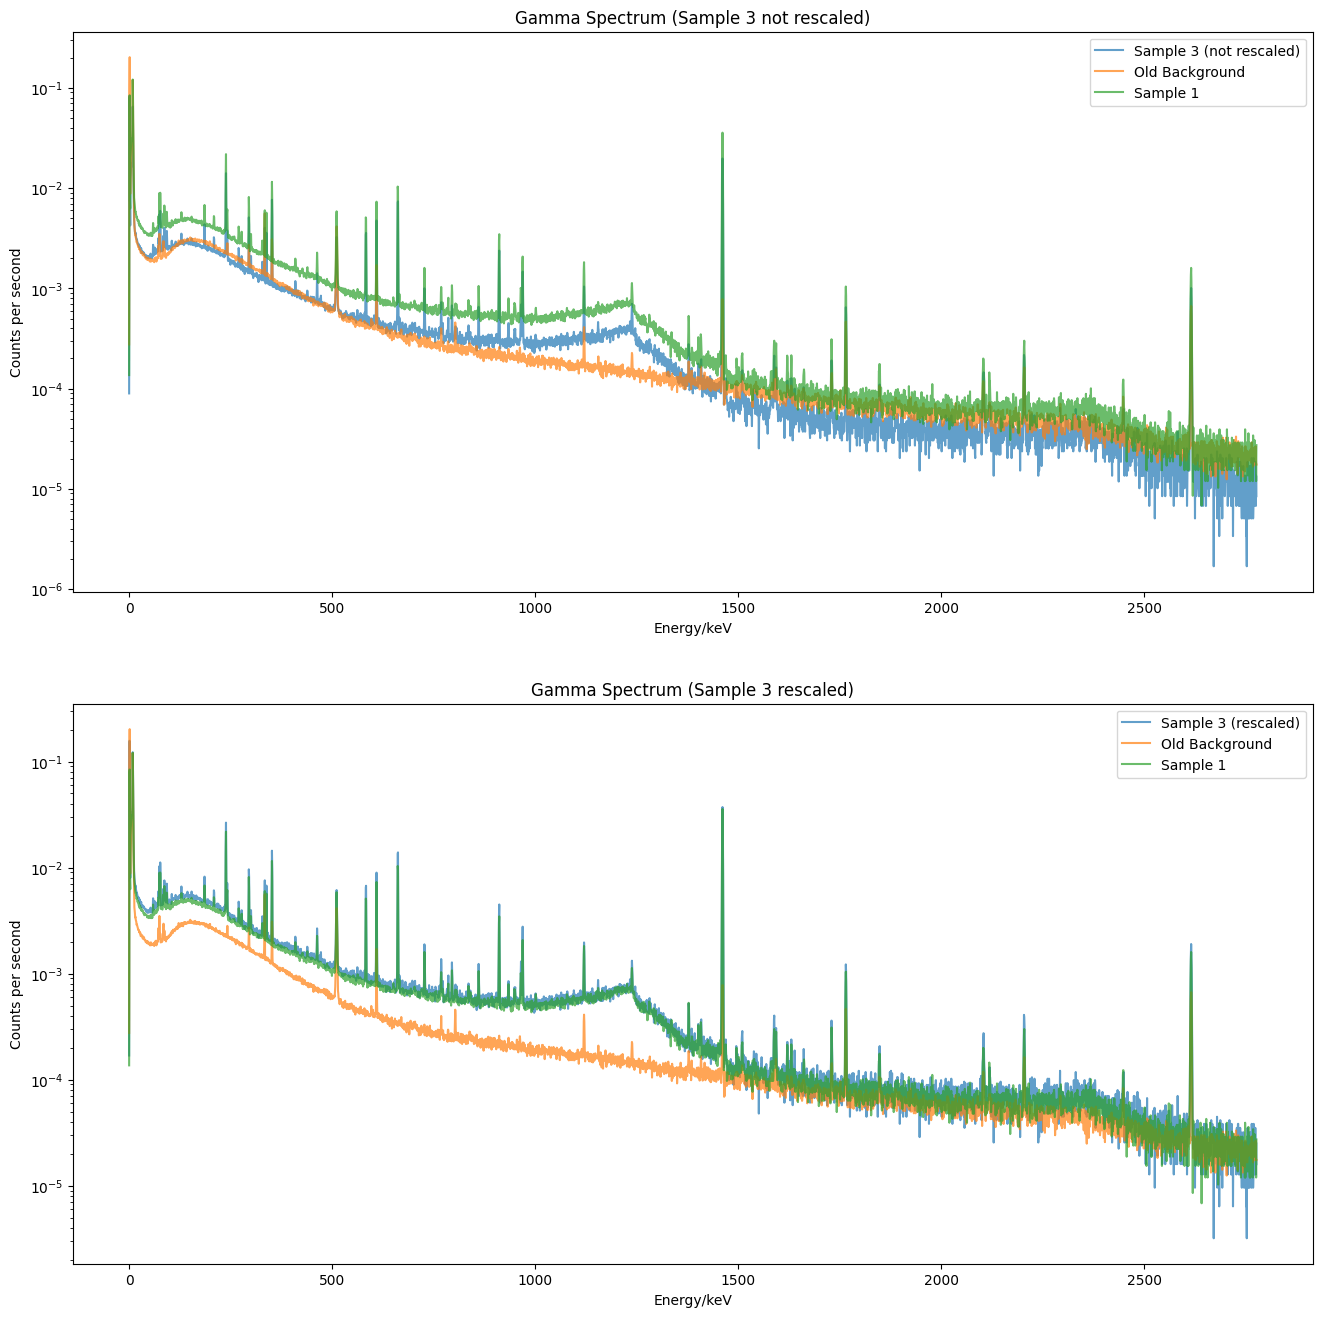

In [176]:
fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize= (16,16))
ax[0].set_title('Gamma Spectrum (Sample 3 not rescaled)')
ax[1].set_title('Gamma Spectrum (Sample 3 rescaled)')
ax[0].plot(spec[3][1],spec[3][2]/live_time[3],alpha = 0.7,label = 'Sample 3 (not rescaled)')
ax[1].plot(spec[3][1],spec[3][2]/live_time[3]*scale_factor,alpha = 0.7,label = 'Sample 3 (rescaled)') 
for n in range(2):
    for i in [6,1]:
        ax[n].plot(spec[i][1],spec[i][2]/live_time[i],label=label_list[i],alpha = 0.7)
    ax[n].legend()
    ax[n].set_ylabel('Counts per second')
    ax[n].set_xlabel('Energy/keV')
    ax[n].set_yscale('log')
   
    

In [6]:
from scipy import ndimage
from scipy import stats
from scipy import signal

In [27]:
stats.norm.pdf()

1.4867195147342979e-06

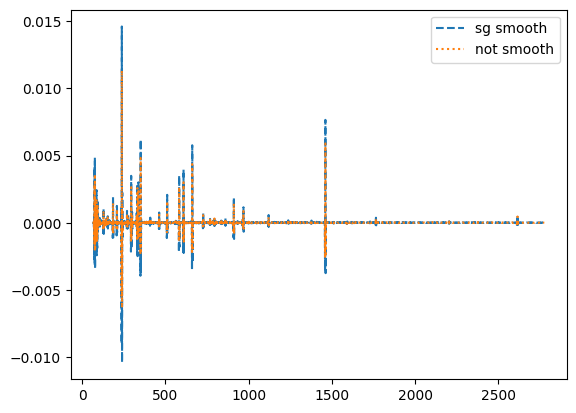

In [490]:
i=5
cps = spec[i][2]/live_time[i] #counts per sec
window_size = 7# Adjust the window size as per your requirements
cps_smooth = np.convolve(cps, np.ones(3)/3, mode='same')
cps_smooth2 = signal.savgol_filter(cps,window_size,3)

sigma = 1.35
x =np.arange(-2,3,1)
gauss_d2 = (x**2/sigma**4 - 1/sigma**2)*np.exp(x**2/2/sigma**2)/np.sqrt(2*np.pi)/sigma
cps_d2 = np.gradient(np.gradient(cps))
cps_d2_smooth2 = signal.savgol_filter(cps_d2,window_size,1)
cps_d2_smooth3 = signal.savgol_filter(cps,7,4,deriv = 2)
n_low = 2000
n_up = 2500
# plt.plot(E_arr[n_low:n_up],cps_d2[n_low:n_up],':',label = 'not smooth')
plt.plot(E_arr[100:],-cps_d2_smooth3[100:],'--',label = 'sg smooth')
plt.plot(E_arr[100:],-cps_d2[100:],':',label = 'not smooth')
#plt.plot(E_arr[100:],cps[100:],':')
plt.legend()

In [418]:
peak_ch, attr = signal.find_peaks(-cps_d2_smooth3[80:],height = 0.00003*np.exp(-np.linspace(0,1,len(cps_d2_smooth2[80:]))))

In [488]:

peak_info_df = pd.DataFrame(columns = ['nndc_peak_energy',
    'mu' ,'sigma','h',
    'mu_err', 'sigma_err', 'h_err'
])

def gauss(x,mu,sigma,h):
    """This function returns a normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return h*stats.norm.pdf(x,loc = mu, scale = sigma)

def d2_gauss_centred(x,sigma,h):
    """This function returns a normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return -np.gradient(np.gradient(h*stats.norm.pdf(x,scale = sigma)))

def d2_gauss(x,mu,sigma,h):
    """This function returns the negative second difference of 
       normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x 
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return -np.gradient(np.gradient(gauss(x,mu,sigma,h))) #negative second difference

def gauss_double(x,mu1,mu2,sigma1,sigma2,h1,h2):
    """This function returns a normalized doublet gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x
       mu   centroid 
       sigma    standard deviation 
       h    peak height 
       """
    return h1*stats.norm.pdf(x,loc = mu1, scale = sigma1) + h2*stats.norm.pdf(x,loc = mu2, scale = sigma2)

def d2_gauss_double(x,mu1,mu2,sigma1,sigma2,h1,h2):
    """This function returns the negative second difference of 
       normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x 
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return -np.gradient(np.gradient(gauss_double(x,mu1,mu2,sigma1,sigma2,h1,h2))) #negative second difference


for index in range(len(iaea_df)):
    E = iaea_df['nndc_peak_energy'][index]
    i = energy_to_chan(E)
    i = int(i)
    param_c,cov_c = curve_fit(d2_gauss_centred,chan_to_energy(np.arange(-6,7)),
    -cps_d2_smooth3[i-6:i+7])
    print(param_c)
    param,cov = curve_fit(d2_gauss,chan_to_energy(np.arange(i-6,i+7)),
    -cps_d2_smooth3[i-6:i+7],p0 = [E,param_c[0],param_c[1]])
    param_err = np.sqrt(np.diag(cov))

    peak_new =pd.DataFrame({
        'nndc_peak_energy' : [E],
        'mu' : [param[0]],'sigma': [param[1]],'h':[param[2]],
        'mu_err': [param_err[0]], 'sigma_err': [param_err[1]], 'h_err':[param_err[2]]
    })
    peak_info_df = pd.concat([peak_info_df,peak_new])
    

[ 9.29984788e-01 -6.71802996e-04]
[1.30616679e+00 1.00761798e-03]
[ 1.17481200e+00 -9.80774683e-04]
[1.61318088 0.00305033]
[1.63514394e+00 7.97190301e-04]
[2.11098224 0.0057556 ]
[2.23059036 0.00533375]
[1.68156268 0.01308097]
[1.27336118e+00 1.18925721e-03]
[1.45506131 0.00279234]
[2.18416176e+00 6.09278879e-04]
[1.31868799e+00 4.14032263e-04]
[1.50446961 0.00180775]
[1.35607648e+00 3.74231927e-04]
[1.79527617e+00 3.50585083e-04]
[2.08576967 0.01278192]
[ 1.24566938 -0.00255335]
[1.79408391 0.00608924]
[1.00827040e+00 4.00413965e-04]
[1.63347412e+00 4.01061786e-04]
[2.88022692 0.00967568]
[1.96621685 0.05994374]
[2.00607575 0.0094961 ]
[1.38297707 0.00234954]
[2.42064766 0.01401082]
[1.39506558 0.01897643]
[1.55752652 0.01515734]
[1.95112296e+00 1.11572800e-03]
[2.32476013e+00 9.19473119e-04]
[1.8019617  0.00365694]
[2.55035284e+00 4.71378612e-04]
[1.75716190e+00 1.34820227e-03]
[1.69392918e+00 3.51775500e-04]
[1.56887539e+00 8.14654503e-04]
[1.79016293e+00 5.46432017e-04]
[1.6776935

In [487]:
h = np.array([1,2])
mu = np.array([1,2])
sigma = np.array([1,2])
pdf = 0
for i in range(len(h)):
    pdf += h[i]*stats.norm.pdf(x,loc = mu[i], scale = sigma[i])

In [471]:
peak_info_df

,nndc_peak_energy,mu,sigma,h,mu_err,sigma_err,h_err
0,59.5409,60.251981,0.829331,-0.002291,0.161672,0.215569,0.001175
0,63.2900,62.167545,0.605515,0.001512,0.132051,0.193172,0.000709
0,100.4100,99.818518,0.500328,-0.000683,0.189422,0.368265,0.000543
0,129.0650,127.915970,0.395200,0.002471,0.045950,0.060133,0.000408
0,153.9770,152.924222,0.443138,0.001329,0.057468,0.086234,0.000282
0,209.2530,208.167540,0.420256,0.003773,0.026576,0.071152,0.000458
0,270.2450,269.147973,0.543234,0.002990,0.017601,0.029591,0.000204
0,338.3200,337.326064,0.465642,0.007881,0.030707,0.045228,0.000892
0,409.4620,408.668129,0.515855,0.001194,0.024060,0.040730,0.000112
0,463.0040,462.093268,0.496514,0.002137,0.021083,0.032804,0.000169


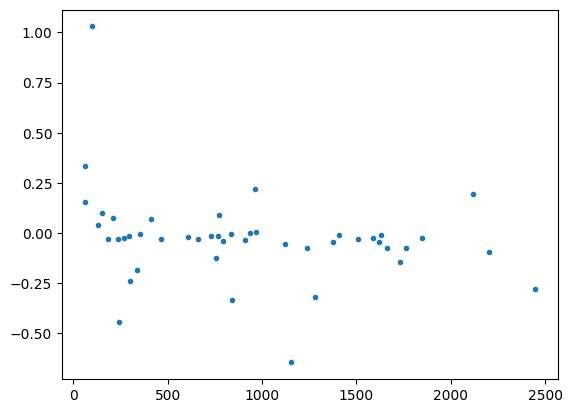

In [466]:
peak_info_df.reset_index(drop = True,inplace = True)
peak_info_df#[peak_info_df['peak h'] < 0]
iaea_df_fit = iaea_df.merge(peak_info_df,on = 'nndc_peak_energy')
#[['nndc_peak_energy','Centroid','mu','Peak_CPS','h', 'FWHM', 'sigma']]
plt.plot(iaea_df_fit['nndc_peak_energy'],iaea_df_fit['sigma']-iaea_df_fit['FWHM']/2.35,'.')

In [405]:
i = int(energy_to_chan(840))

param,cov = curve_fit(d2_gauss_double,chan_to_energy(np.arange(i-6,i+7)),
    -cps_d2_smooth3[i-6:i+7],p0 = [E,param_c[0],param_c[1]])

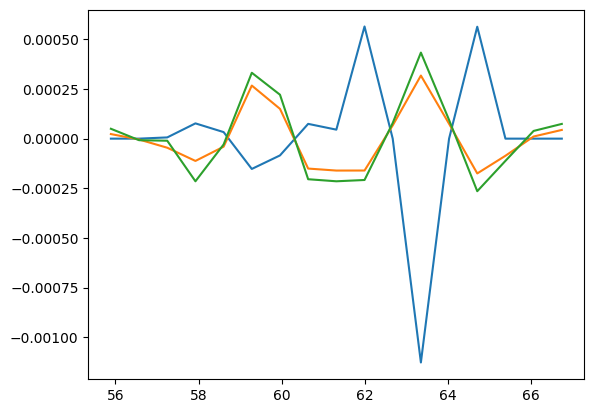

In [520]:
def gauss(x,mu,sigma,h):
    """This function returns a normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return h*stats.norm.pdf(x,loc = mu, scale = sigma)
def d2_gauss(x,mu,sigma,h):
    """This function returns the negative second difference of 
       normalized gaussian probability density function
       multiplied by peak height h (area under curve = h)
       Inputs:
       x    variable x 
       mu   centroid
       sigma    standard deviation
       h    peak height
       """
    return -np.gradient(np.gradient(gauss(x,mu,sigma,h))) #negative second difference


i1 = int(energy_to_chan(59.5))
i2 = int(energy_to_chan(63.4))
loc_l = i1-6
loc_h = i2+5
param,cov = curve_fit(lambda x, sigma1, sigma2, h1, h2 : d2_gauss_double(x, 59.5,63.4,sigma1, sigma2, h1, h2),
chan_to_energy(np.arange(loc_l,loc_h)),
    -cps_d2_smooth3[loc_l:loc_h],p0 = [0.2,0.2,0.00025,0.00035])


plt.plot(E_arr[loc_l:loc_h],d2_gauss_double(E_arr[loc_l:loc_h],59.5,63.4,*param))
plt.plot(E_arr[loc_l:loc_h],-cps_d2[loc_l:loc_h])
plt.plot(E_arr[loc_l:loc_h],-cps_d2_smooth3[loc_l:loc_h])
#plt.plot(E_arr[80:],0.00002*np.exp(-np.linspace(0,2,len(cps_d2_smooth2[80:]))))

In [473]:
param

array([8.4e+02, 1.0e+00, 5.0e-03])

In [313]:
print(cov)
print(np.sqrt(np.diag(cov)))

[[ 8.30243072e-03 -3.92465311e-08  9.20875298e-11]
 [-3.92465311e-08  1.28944638e-02  1.64673814e-05]
 [ 9.20875298e-11  1.64673814e-05  2.90853448e-08]]
[0.09111768 0.11355379 0.00017054]


In [ ]:
chi2

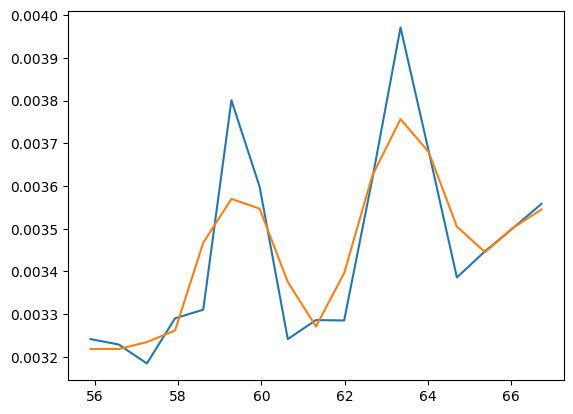

In [513]:
#plt.plot(E_arr[loc_l:loc_h],gauss(E_arr[loc_l:loc_h],*param))
plt.plot(E_arr[loc_l:loc_h],cps[loc_l:loc_h])
plt.plot(E_arr[loc_l:loc_h],cps_smooth[loc_l:loc_h])

In [304]:
param[2]

0.0006390527638689837

In [303]:
param[2]*stats.norm.cdf(1e10,loc = param[0], scale = param[1])

0.0006390527638689837

In [163]:
[E_peak == 511.2338401]


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False])]

In [154]:
E_peak = E_arr[loc+np.full(len(loc),80)]

array([  58.60123064,   64.02153758,   88.41305164,   93.83341763,
         99.25379435,  104.67418181,  114.83743723,  128.38850317,
        144.64987088,  153.45815207,  185.3037129 ,  204.95328636,
        209.69630799,  234.0891205 ,  238.15461039,  270.0011568 ,
        278.13224931,  295.74969929,  299.81528077,  327.59691589,
        333.01775562,  339.11621315,  352.66838965,  409.58826371,
        463.79876806,  511.2338401 ,  563.41336877,  583.74332451,
        609.49481853,  661.67622021,  666.42003332,  727.41264842,
        755.19862359,  768.07514673,  786.373468  ,  795.18381445,
        802.63874513,  831.10321262,  835.16958928,  839.91370301,
        860.92344834,  911.0763954 ,  934.79770386,  964.61906893,
        969.36340695, 1120.50876327, 1155.0768106 , 1238.44860229,
       1281.15221019, 1378.08509267, 1401.81044662, 1408.58915692,
       1461.463673  , 1496.71391742, 1509.59392757, 1588.23109255,
       1593.65442851, 1620.77126939, 1630.94015391, 1729.91926

In [91]:
h

{'prominences': array([1.21235013e-04, 5.53413144e-05, 1.23664979e-04, 5.61394437e-05,
        7.79166334e-05, 4.48102768e-05, 1.36418445e-04, 7.12955993e-05,
        5.13571904e-04, 1.32526230e-04, 3.13486933e-04, 1.31259660e-04,
        5.63773408e-04, 8.54235555e-05, 1.81808640e-04, 3.40574706e-05,
        6.70487923e-05, 2.54013846e-05, 1.01296011e-04, 3.07605917e-05,
        7.19941107e-05, 1.44552723e-05, 3.78263488e-05, 1.20039598e-05,
        1.06662334e-04]),
 'left_bases': array([  26,   34,   34,   52,  273,  281,   34,  359,  409,  416,  416,
         443,  416,  678,  678,  823,  823, 1577,  823, 2080, 2080, 2528,
        2528, 3176,  823]),
 'right_bases': array([ 409,   41,  351,  273,  351,  351,  409,  409,  416,  435,  670,
         670,  678,  815,  823, 1569, 2072, 2072, 2080, 2520, 3773, 3167,
        3773, 3773, 3782])}

### Cs-137


In [304]:
cs137['Peak_CPS']

1  16    0.024179
2  17    0.025708
3  15    0.017786
4  19    0.036625
5  22    0.024243
Name: Peak_CPS, dtype: float64

([<matplotlib.axis.XTick at 0x134d24040>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

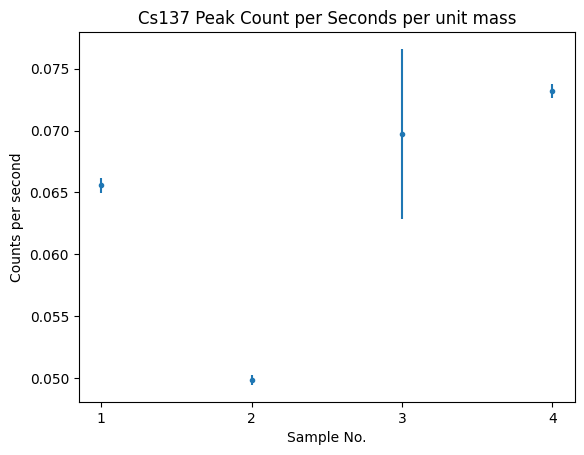

In [308]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
cs137 = df[df['Nuclide']=='Cs137']
cs137_err = (cs137['Net_Area_err']/cs137['Net_Area_Count']*cs137['Peak_CPS'])[:-1]/sample_mass
#error propagated to include scaling factor error
cs137_err[3] = cs137['Peak_CPS'][3]*np.sqrt((cs137_err[3]/cs137['Peak_CPS'][3])**2+(scale_factor_err/scale_factor)**2)
plt.errorbar(np.arange(1,5,1),cs137['Peak_CPS'].to_numpy()[:-1]*np.array([1,1,scale_factor,1])/sample_mass
,yerr = cs137_err ,fmt='.')
plt.ylabel('Counts per second')
plt.xlabel('Sample No.')
plt.title('Cs137 Peak Count per Seconds per unit mass')
plt.xticks(range(1,5))

In [307]:
cs137_err[2]

17    0.009938
dtype: float64

### Plots of counts / branching ratio of nuclides at different energies

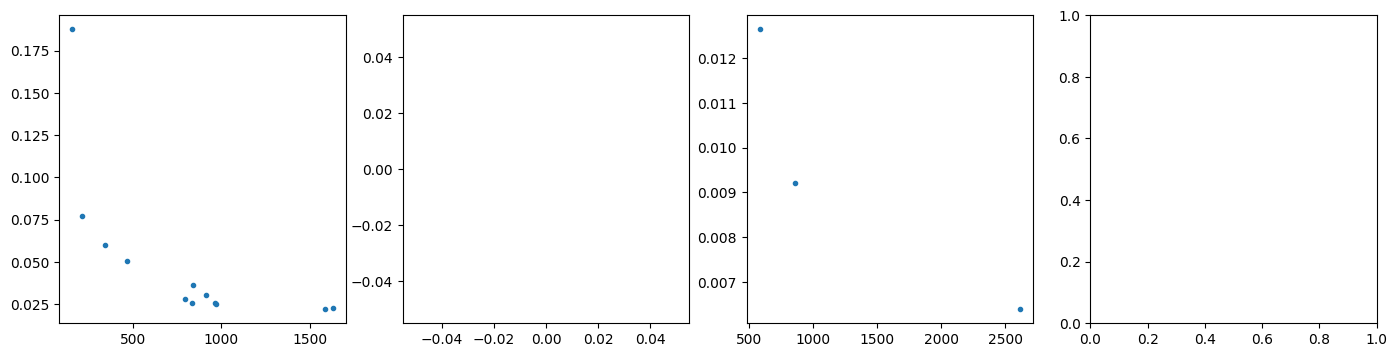

In [78]:
U238_chain = ['Th234','Pa234m','Ra226','Pb214','Bi214']
Th232_chain = ['Ac228','Bi212','Tl208']
def rel_activity(df0,chain):
        fig,ax = plt.subplots(1,4,figsize = (17,4))
        i = 0
        for nuclide in chain:
                df = df0[df0['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
                ax[i].plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.')
                i +=1
        plt.show()
        
rel_activity(df_1,Th232_chain)

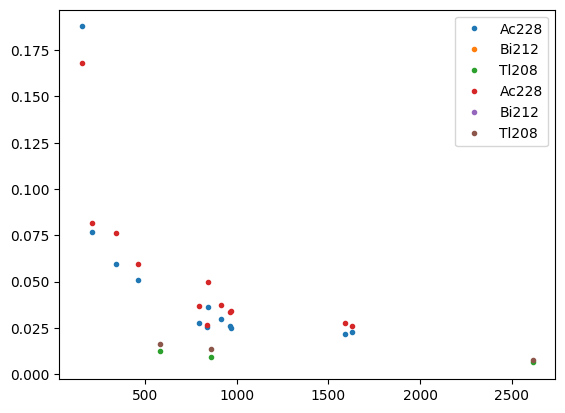

In [96]:
plt.figure()
i = 0

for nuclide in Th232_chain:
    df = df_1[df_1['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
for nuclide in Th232_chain:
    df = df_2[df_2['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
    


In [156]:
diff = df_1['Centroid'][1:].to_numpy()-df_1['Centroid'][:-1].to_numpy()
df_1[:-1][diff<3*df_1['FWHM'][:-1].to_numpy()]['Reduced']

1     56.12
32     1.97
42     1.23
Name: Reduced, dtype: float64

In [177]:
def compton_edge(energy):
    '''This takes in energy of a peak, and returns the compton edge associated with the peak'''
    ratio = energy/511 #energy to electron rest energy  ratio
    return energy*(2*ratio/(2*ratio+1))
compton_edge(1460.75)
compton_edge(2614.53)

2381.7754939495408

Intensity / 100 = Branching ratio (BR)

In [282]:
df.loc[range(1,6)].groupby('Photopeak_Energy').max()

,Centroid,Nuclide,Net_Area_Count,Net_Area_err,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,nndc_peak_energy,E_err,BR,BR_err,T1/2(s),Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR
Photopeak_Energy,,,,,,,,,,,,,,,,,,,
59.54,59.86,Am241,937.0,121.9,0.000784,0.61,2.24,60.0,Am241,59.5409,1.0E-4,0.35900,0.4,1.365000e+10,0.008463,0.014091,0.010190,0.000235,0.002183
62.86,63.49,Th234,402.7,98.5,0.000683,1.44,1.32,63.0,Th234,63.2900,0.02,0.03700,0.4,2.082240e+06,0.030473,0.050741,0.022681,0.000799,0.018471
63.29,63.71,Th234,1277.5,161.5,0.001069,1.29,14.30,63.0,Th234,63.2900,0.02,0.03700,0.4,2.082240e+06,0.023446,0.039041,0.020344,0.000616,0.028881
74.82,75.55,Pb212 (x-ray),12825.2,161.3,0.010727,1.49,56.12,75.0,Pb212,74.8150,,0.09900,0.3,3.823920e+04,0.010212,0.017005,0.019722,0.000225,0.108354
77.11,77.47,Pb212 (x-ray),16318.1,172.4,0.013649,1.47,56.12,77.0,Pb212,77.1070,,0.16400,0.4,3.823920e+04,0.009477,0.015781,0.018975,0.000204,0.083226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847.42,1848.62,Bi214,484.5,36.9,0.000574,2.97,1.67,1847.0,Bi214,1847.4330,0.017,0.02027,0.14E-6,1.182600e+03,0.081559,0.135805,0.001607,0.000073,0.028319
2118.55,2119.72,Bi214,341.0,35.2,0.000310,2.66,2.12,2119.0,Bi214,2118.5130,0.03,0.01156,0.13E-7,1.182600e+03,0.133025,0.221502,0.001255,0.000104,0.026785
2204.21,2204.88,Bi214,1069.5,43.9,0.001166,2.64,1.64,2204.0,Bi214,2204.1000,0.04,0.04920,0.05E-6,1.182600e+03,0.048229,0.080307,0.001197,0.000036,0.023691
